# Compare different BBPE tokenizers
The task is to transparently inspect some of the characteristics of different BBPE tokenizers. The tokenizers were trained with different minimum frequency thresholds so they have different vocabularies (and importantly different vocabularies sizes)

The tokenizers are:
- mf3: the standard one we've used so far
- mf30
- mf3000

look for:
- num of trained and special tokens
- average token length in vocabulary
- average chars per token in NIST train set
- visualize the token usage distribution

In [2]:
import pandas as pd
from tokenizers import Tokenizer
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def get_vocab_size(tokenizer):
    return len(tokenizer.get_vocab())

def get_mean_token_len(tokenizer):
    vocab = tokenizer.get_vocab()
    mean_len = sum(map(lambda x: len(x), vocab.keys())) / len(vocab)
    return mean_len

def mean_chars_per_token(df):
    all_smiles_len = sum(df['mol_repr'].apply(len))
    num_all_tokens = sum(df['labels'].apply(lambda x: len(x) - 2))
    return all_smiles_len / num_all_tokens

def visualize_token_usage(df, tokenizer_name):
    all_tokens = []
    for alist in df["labels"]:
        all_tokens += alist
    c = Counter(all_tokens)
    
    fig, ax = plt.subplots()
    ax.bar(c.keys(), c.values())
    ax.set_yscale('log')
    ax.set_title(f"Token usage distribution: {tokenizer_name}")

    plt.show()
    return c

def get_n_most_frequent_tokens(n, counter, tokenizer):
    most_common_ids = counter.most_common(n)
    most_common_tokens = [(tokenizer.decode([count[0]]), count[0], count[1]) for count in most_common_ids]
    return most_common_tokens

First print some basic information about all the trained tokenizers to decide which we choose for the experiment.

bart_bbpe_tokenizer_1M_mf3
- min_frequency: 3
- init alphabet size: 256
- num of special tokens: 11
- num of trained tokens: 1560
- the whole vocabulary size: 1827
- mean length of tokens: 5.934865900383142

bart_bbpe_tokenizer_1M_mf10
- min_frequency: 10
- init alphabet size: 256
- num of special tokens: 11
- num of trained tokens: 1019
- the whole vocabulary size: 1286
- mean length of tokens: 4.917573872472784

bart_bbpe_tokenizer_1M_mf30
- min_frequency: 30
- init alphabet size: 256
- num of special tokens: 11
- num of trained tokens: 718
- the whole vocabulary size: 985
- mean length of tokens: 4.154314720812183

bart_bbpe_tokenizer_1M_mf50
- min_frequency: 50
- init alphabet size: 256
- num of special tokens: 11
- num of trained tokens: 620
- the whole vocabulary size: 887
- mean length of tokens: 3.8173618940248026

bart_bbpe_tokenizer_1M_mf100
- min_frequency: 100
- init alphabet size: 256
- num of special tokens: 11
- num of trained tokens: 513
- the whole vocabulary size: 780

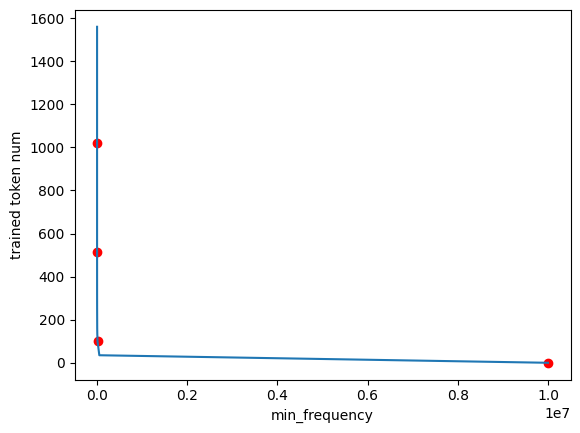

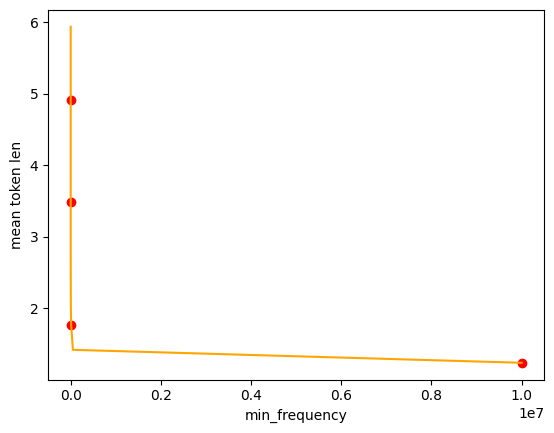

In [4]:
# print basic information
save_path = '../tokenizer/bbpe_tokenizer/'
mfs = [3, 10, 30, 50, 100, 500, 1000, 3000, 5000, 6000, 10000, 50000, 10000000]
trained_token_nums = []
mean_token_lens = []
mfs_to_highlight = [10, 100, 10000, 10000000]

for min_frequency in mfs:
    # loading the saved tokenizer
    tokenizer = Tokenizer.from_file(save_path + f"/bart_bbpe_tokenizer_1M_mf{min_frequency}.model")
    trained_token_nums.append(len(tokenizer.get_vocab()) - 256 - 11)
    mean_token_lens.append(get_mean_token_len(tokenizer))
    print(f"bart_bbpe_tokenizer_1M_mf{min_frequency}\n" +
          f"- min_frequency: {min_frequency}\n" +
          f"- init alphabet size: 256\n" +
          f"- num of special tokens: 11\n" +
          f"- num of trained tokens: {trained_token_nums[-1]}\n" +
          f"- the whole vocabulary size: {len(tokenizer.get_vocab())}\n" +
          f"- mean length of tokens: {mean_token_lens[-1]}\n")
    
# visualize the trained token num
fig1, ax1 = plt.subplots()
ax1.set_label("trained token num")
ax1.set_xlabel("min_frequency")
ax1.set_ylabel("trained token num")

ax1.plot(mfs, trained_token_nums)
ax1.scatter(mfs_to_highlight, [trained_token_nums[mfs.index(n)] for n in mfs_to_highlight], color='red')

# visualize the mean token length
fig2, ax2 = plt.subplots()
ax2.set_label("mean token len")
ax2.set_xlabel("min_frequency")
ax2.set_ylabel("mean token len")

ax2.plot(mfs, mean_token_lens, color='orange')
ax2.scatter(mfs_to_highlight, [mean_token_lens[mfs.index(n)] for n in mfs_to_highlight], color='red')
plt.show()

So from these we choose mfs 10, 100 and 10000 for further inspection and the experiment.

MF10
mean_chars_per_token: 1.5744450788933846


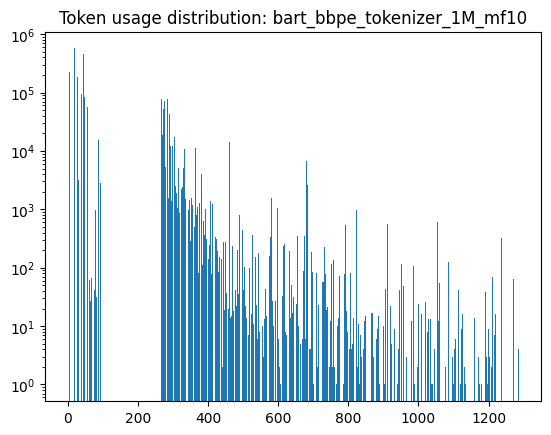

MF100
mean_chars_per_token: 1.5613584778012686


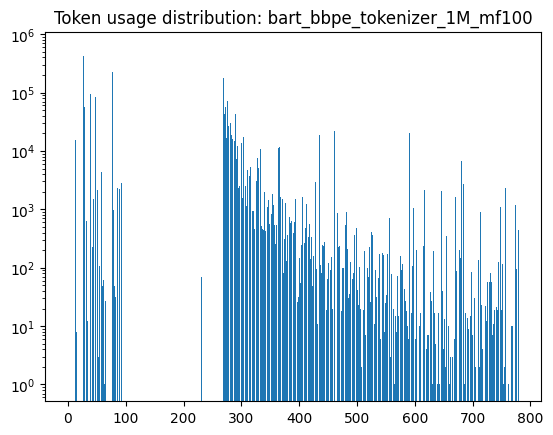

MF10000
mean_chars_per_token: 1.490505938753117


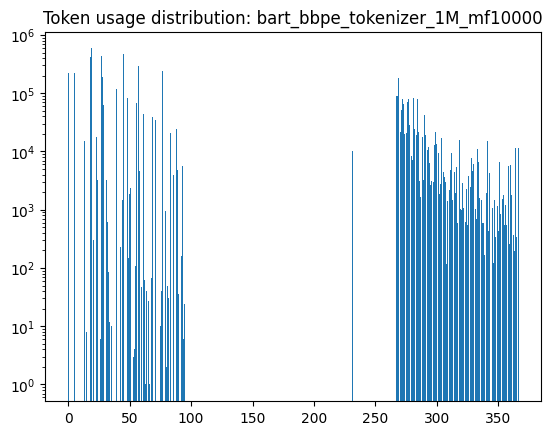

MF10000000
mean_chars_per_token: 0.9685616968986828


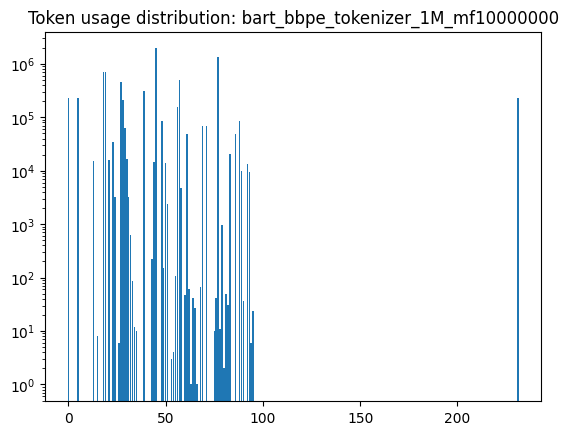

In [6]:
chosen_mfs = [10, 100, 10000, 10000000]
all_counts = {}
for mf in chosen_mfs:
    print(f"MF{mf}")
    df = pd.read_json(f"../data/datasets/NIST/NIST_split_filip/mf{mf}/train.jsonl", lines=True)
    tokenizer = Tokenizer.from_file(save_path + f"/bart_bbpe_tokenizer_1M_mf{mf}.model")
    print(f"mean_chars_per_token: {mean_chars_per_token(df)}")
    count = visualize_token_usage(df, f"bart_bbpe_tokenizer_1M_mf{mf}")
    all_counts[mf] = count

In [11]:
for i, data in enumerate([data_mf3, data_mf30, data_mf3000]):
    num_all_tokens = sum(data['labels'].apply(lambda x: len(x) - 2))
    print(num_all_tokens)

4635552
4686110
4800229


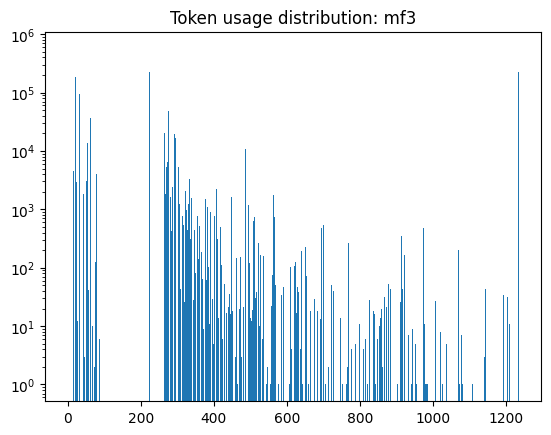

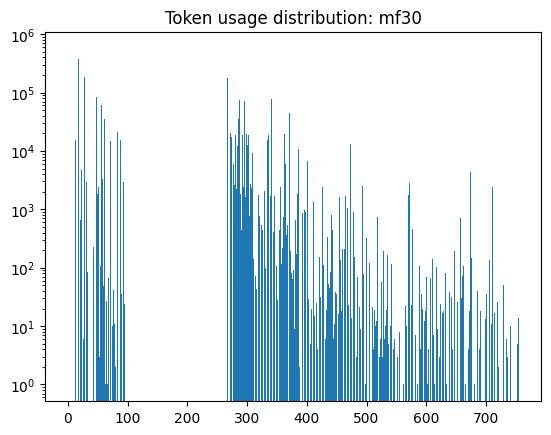

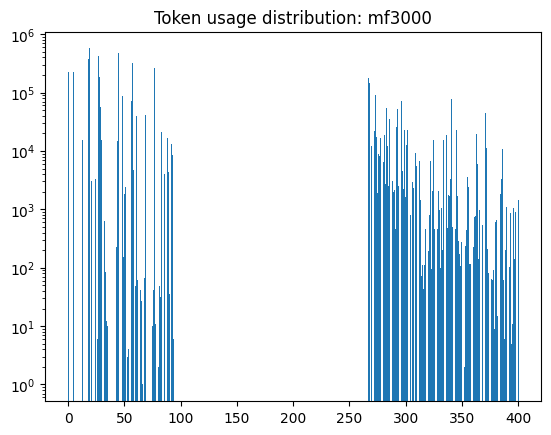

In [47]:
# visualize_token_usage - old data
old_mfs = [3, 30, 3000]
for mf in old_mfs:
    data = pd.read_json(f"../data/datasets/NIST/NIST_split_filip/mf{mf}/train.jsonl", lines=True)
    count = visualize_token_usage(data, f"mf{mf}")
    all_counts[mf] = count

### Where are these Ġ still popping up?
Let's investigate a bit where is this peak in the middle of a valley coming from.

In [67]:
# find a smiles with a token 231
data["contains_space"] = data["labels"].apply(lambda x: 231 in x)
data

,input_ids,position_ids,mol_repr,labels,mz,intensity,contains_space
0,"[26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39, 4...","[2, 7, 4, 9, 1, 3, 1, 0, 0, 0, 6, 3, 9, 6, 9, ...",CCCCCCCCC(CCCC)O[Si]1(C)CCCCC1,"[5, 231, 303, 363, 18, 303, 19, 57, 69, 61, 83...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 35.0, 36....","[21.98, 335.7, 49.95, 737.34, 10.99, 25.98, 8....",True
1,"[27, 29, 39, 41, 42, 43, 53, 54, 55, 56, 57, 6...","[1, 3, 0, 3, 3, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, ...",CCCCOC(=O)C1CCN(C(=O)c2ccc(F)c(F)c2)CC1,"[5, 231, 268, 299, 267, 57, 19, 45, 27, 276, 1...","[27.0, 29.0, 39.0, 41.0, 42.0, 43.0, 53.0, 54....","[8.99, 25.98, 7.99, 24.98, 29.97, 2.0, 4.0, 5....",True
2,"[29, 30, 31, 38, 39, 40, 41, 42, 43, 45, 54, 5...","[7, 5, 5, 2, 5, 4, 5, 6, 6, 3, 6, 5, 9, 3, 4, ...",CON=C(C)C,"[5, 231, 277, 56, 39, 45, 18, 45, 19, 45, 0]","[29.0, 30.0, 31.0, 38.0, 39.0, 40.0, 41.0, 42....","[209.81, 99.91, 79.93, 19.98, 79.93, 59.95, 10...",True
3,"[27, 28, 29, 30, 39, 41, 42, 44, 46, 50, 51, 5...","[2, 2, 3, 1, 1, 3, 0, 2, 0, 1, 1, 1, 0, 2, 4, ...",CCCCOC(=O)CCNC(=O)c1ccc(Cl)cc1,"[5, 231, 268, 299, 267, 57, 19, 290, 267, 57, ...","[27.0, 28.0, 29.0, 30.0, 39.0, 41.0, 42.0, 44....","[17.98, 15.99, 39.96, 8.99, 8.99, 27.97, 5.0, ...",True
4,"[29, 39, 41, 42, 43, 53, 54, 55, 56, 57, 65, 6...","[0, 0, 2, 0, 3, 0, 1, 4, 1, 3, 0, 2, 1, 2, 0, ...",CCCCCCCCCCCOC(=O)c1ccccc1C(=O)OC1CCCCCC1,"[5, 231, 303, 303, 268, 292, 267, 57, 19, 77, ...","[29.0, 39.0, 41.0, 42.0, 43.0, 53.0, 54.0, 55....","[4.0, 3.0, 20.98, 5.0, 30.97, 2.0, 8.99, 63.94...",True
...,...,...,...,...,...,...,...
224728,"[39, 41, 43, 44, 50, 51, 55, 56, 57, 59, 71, 7...","[3, 4, 0, 2, 2, 5, 5, 1, 2, 2, 2, 2, 8, 4, 2, ...",CCCCC(C(C)=O)C(=O)c1ccccc1,"[5, 231, 363, 18, 45, 18, 45, 281, 57, 19, 45,...","[39.0, 41.0, 43.0, 44.0, 50.0, 51.0, 55.0, 56....","[29.97, 44.96, 5.99, 19.98, 21.98, 83.92, 100....",True
224729,"[26, 27, 28, 29, 31, 36, 37, 38, 39, 40, 41, 4...","[0, 2, 0, 2, 0, 0, 0, 0, 3, 0, 6, 4, 4, 0, 1, ...",C=CCCCCCCCCOC(=O)CCCC(=O)Oc1cccc(Cl)c1,"[5, 231, 45, 39, 303, 303, 292, 267, 57, 19, 3...","[26.0, 27.0, 28.0, 29.0, 31.0, 36.0, 37.0, 38....","[4.0, 20.98, 7.99, 21.98, 1.0, 2.0, 1.0, 4.0, ...",True
224730,"[14, 15, 17, 18, 26, 27, 28, 29, 30, 31, 32, 3...","[0, 2, 0, 3, 0, 3, 6, 3, 7, 0, 0, 0, 0, 3, 1, ...",CC1CNC(C)CN1,"[5, 231, 268, 27, 282, 18, 45, 19, 270, 27, 0]","[14.0, 15.0, 17.0, 18.0, 26.0, 27.0, 28.0, 29....","[2.0, 19.98, 5.0, 26.98, 5.0, 31.97, 136.88, 2...",True
224731,"[15, 26, 27, 28, 29, 30, 31, 37, 38, 39, 40, 4...","[1, 0, 2, 4, 4, 3, 0, 0, 0, 2, 0, 1, 3, 0, 0, ...",c1ccc(N2CCNCC2)cc1,"[5, 231, 77, 27, 287, 18, 56, 28, 381, 28, 19,...","[15.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 37....","[8.99, 4.0, 19.98, 55.95, 50.95, 35.97, 1.0, 2...",True


### Missing tokens
Which tokens are completely missing in the dataset at all? Are those somehow special?

In [51]:
def get_missing_tokens(count, tokenizer):
    all_token_ids = set(range(max(count.keys())))
    present_token_ids = set(count.keys())
    missing_ids = sorted(list(all_token_ids - present_token_ids))
    missing_tokens = [(tokenizer.decode([id]), id) for id in missing_ids]
    return missing_tokens

In [68]:
# compare new with old training data: number of missed tokens
tokenizers = {mf: Tokenizer.from_file(save_path + f"/bart_bbpe_tokenizer_1M_mf{mf}.model") for mf in old_mfs + chosen_mfs}

for mf in (old_mfs + chosen_mfs):
    missing_tokens = get_missing_tokens(all_counts[mf], tokenizers[mf])
    print(f"missing tokens mf{mf}:", len(missing_tokens))

missing tokens mf3: 580
missing tokens mf30: 294
missing tokens mf3000: 212
missing tokens mf10: 441
missing tokens mf100: 230
missing tokens mf10000: 206


In [71]:
missing_token = 231 not in all_counts[3]
print(f"Is token 231 missing in mf3? {missing_token}")


Is token 231 missing in mf3? True


# SMAZ
Ale.. chtelo by to canonizovat smilesy z 1M pred treninkem tokenizeru. Budou tam pak asi relevantnejsi tokeny. Je to vubec canonicky?

In [97]:
data_path = "../tokenizer/training_data/1M.txt"
with open(data_path, "r") as file:
    smiless = file.read().split(" ")

In [1]:
smiless[0]

NameError: name 'smiless' is not defined